## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import os
import glob
from google.colab import drive

## connect your drive with the notebook
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
project_folder = "/content/drive/MyDrive/DSBA M2/2 Advanced Deep Learning/Practical Session 1/最终交的"

In [ ]:
# project_folder = "drive/My Drive/ADL/TP1"

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [26]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir(project_folder+'/USPS/'):
    os.mkdir(project_folder+'/USPS/')
open(project_folder+'/USPS/usps.bz2', 'wb').write(r.content)

6579383

In [27]:
# Loading USPS dataset from torchvision.dataset
# 原来datasets就有这么个东西...
dataset = torchvision.datasets.USPS(root=project_folder+'/USPS/',
                                    train=True, 
                                    transform=transforms.ToTensor(),
                                    download=False)

In [6]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: /content/drive/MyDrive/DSBA M2/2 Advanced Deep Learning/Practical Session 1/最终交的/USPS/
    StandardTransform
Transform: ToTensor()

In [7]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [8]:
len(inputs)

7291

In [9]:
inputs[0].shape

(16, 16)

In [29]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 6')

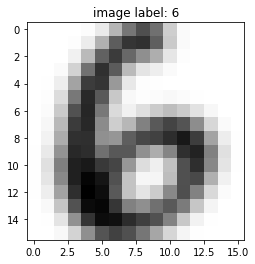

In [30]:
sample_index = 89
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

In [31]:
class Model(nn.Module):
    
    def __init__(self, hidden_layer=100, activation=F.softmax):
        super(Model, self).__init__()
        
        self.activation = activation
        self.l1 = nn.Linear(16*16, hidden_layer)
        self.l2 = nn.Linear(hidden_layer, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h = F.relu(self.l1(inputs))
        if self.activation is None:
          outputs = self.l2(h)
        elif self.activation == F.softmax:
          outputs = self.activation(self.l2(h), dim=1) # Use softmax as the activation function for the last layer
        else:
          outputs = self.activation(self.l2(h))
        return outputs

## Train your Model

In [32]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [33]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, reshape=True, logs=True):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            if reshape:
                y_pre = model(images.view(batch_size, -1)) 
                #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            else:
                y_pre = model(images)
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if logs:
            print('Epoch [{}/{}], Loss: {:.4f}'
                          .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [34]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0860
Epoch [2/10], Loss: 0.0730
Epoch [3/10], Loss: 0.0587
Epoch [4/10], Loss: 0.0455
Epoch [5/10], Loss: 0.0352
Epoch [6/10], Loss: 0.0271
Epoch [7/10], Loss: 0.0216
Epoch [8/10], Loss: 0.0181
Epoch [9/10], Loss: 0.0158
Epoch [10/10], Loss: 0.0143


Text(0.5, 1.0, 'Visualization of convergence')

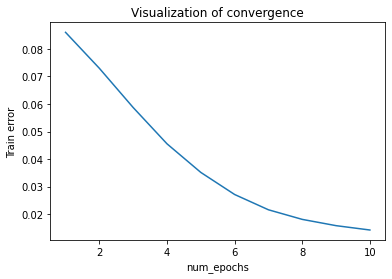

In [35]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [36]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model, reshape=True, logs=True):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            if reshape:
                images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()
    accuracy = correct.item()/ len(dataset)
    if logs:
        print('Accuracy of the model : {:.2f} %'.format(100*accuracy))
    return accuracy

In [27]:
accuracy(val_set, model)

Accuracy of the model : 92.56 %


0.9256390395042603

Text(0.5, 1.0, 'Prediction label: 3')

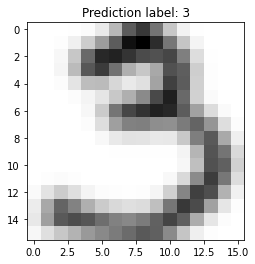

In [28]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

#### a) Convolutional model

In [37]:
class ModelConv(nn.Module):
    
    def __init__(self, activation=F.softmax):
        super(ModelConv, self).__init__()
        
        self.activation = activation
        self.c1 = nn.Conv2d(1, 16, 3, stride=1)
        self.c2 = nn.Conv2d(16, 8, 3, stride=1) # 12x12 images
        self.l3 = nn.Linear(12*12*8, 32)
        self.l4 = nn.Linear(32, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h1 = F.relu(self.c1(inputs))
        h2 = F.relu(self.c2(h1))
        h2 = torch.flatten(h2, start_dim=1)
        h3 = F.relu(self.l3(h2))
        if self.activation is None:
          outputs = self.l4(h3)
        elif self.activation == F.softmax:
          outputs = self.activation(self.l4(h3), dim=1) # Use softmax as the activation function for the last layer
        else:
          outputs = self.activation(self.l4(h3))
        return outputs

Epoch [1/20], Loss: 0.0895
Epoch [2/20], Loss: 0.0637
Epoch [3/20], Loss: 0.0188
Epoch [4/20], Loss: 0.0144
Epoch [5/20], Loss: 0.0127
Epoch [6/20], Loss: 0.0115
Epoch [7/20], Loss: 0.0106
Epoch [8/20], Loss: 0.0099
Epoch [9/20], Loss: 0.0090
Epoch [10/20], Loss: 0.0090
Epoch [11/20], Loss: 0.0081
Epoch [12/20], Loss: 0.0081
Epoch [13/20], Loss: 0.0075
Epoch [14/20], Loss: 0.0070
Epoch [15/20], Loss: 0.0068
Epoch [16/20], Loss: 0.0065
Epoch [17/20], Loss: 0.0061
Epoch [18/20], Loss: 0.0060
Epoch [19/20], Loss: 0.0058
Epoch [20/20], Loss: 0.0056


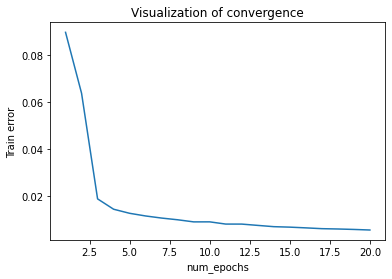

Accuracy of the model : 95.97 %


0.959721146398141

In [38]:
num_epochs = 20
batch_size = 10

model = ModelConv()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, model, reshape=False)


#### b) i. Model with 2 hidden layers

In [16]:
class Model2Hidden(nn.Module):
    
    def __init__(self, hidden_layer_1=100, hidden_layer_2=100):
        super(Model2Hidden, self).__init__()
        
        self.l1 = nn.Linear(16*16, hidden_layer_1)
        self.l2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.l3 = nn.Linear(hidden_layer_2, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h1 = F.relu(self.l1(inputs))
        h2 = F.relu(self.l2(h1))
        outputs = F.softmax(self.l3(h2), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Epoch [1/20], Loss: 0.0894
Epoch [2/20], Loss: 0.0872
Epoch [3/20], Loss: 0.0803
Epoch [4/20], Loss: 0.0721
Epoch [5/20], Loss: 0.0613
Epoch [6/20], Loss: 0.0497
Epoch [7/20], Loss: 0.0379
Epoch [8/20], Loss: 0.0281
Epoch [9/20], Loss: 0.0213
Epoch [10/20], Loss: 0.0173
Epoch [11/20], Loss: 0.0150
Epoch [12/20], Loss: 0.0134
Epoch [13/20], Loss: 0.0122
Epoch [14/20], Loss: 0.0114
Epoch [15/20], Loss: 0.0108
Epoch [16/20], Loss: 0.0103
Epoch [17/20], Loss: 0.0098
Epoch [18/20], Loss: 0.0095
Epoch [19/20], Loss: 0.0091
Epoch [20/20], Loss: 0.0089


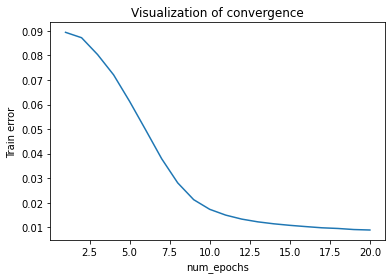

Accuracy of the model : 94.11 %


0.941130906274206

In [32]:
model = Model2Hidden()
num_epochs = 20
batch_size = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, model)

#### b) ii. Model with 3 hidden layers

In [17]:
class Model3Hidden(nn.Module):
    
    def __init__(self, hidden_layer_1=100, hidden_layer_2=100, hidden_layer_3=100):
        super(Model3Hidden, self).__init__()
        
        self.l1 = nn.Linear(16*16, hidden_layer_1)
        self.l2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.l3 = nn.Linear(hidden_layer_2, hidden_layer_3)
        self.l4 = nn.Linear(hidden_layer_3, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h1 = F.relu(self.l1(inputs))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        outputs = F.softmax(self.l4(h3), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Epoch [1/20], Loss: 0.0899
Epoch [2/20], Loss: 0.0895
Epoch [3/20], Loss: 0.0886
Epoch [4/20], Loss: 0.0855
Epoch [5/20], Loss: 0.0799
Epoch [6/20], Loss: 0.0766
Epoch [7/20], Loss: 0.0720
Epoch [8/20], Loss: 0.0651
Epoch [9/20], Loss: 0.0603
Epoch [10/20], Loss: 0.0535
Epoch [11/20], Loss: 0.0446
Epoch [12/20], Loss: 0.0357
Epoch [13/20], Loss: 0.0270
Epoch [14/20], Loss: 0.0210
Epoch [15/20], Loss: 0.0174
Epoch [16/20], Loss: 0.0154
Epoch [17/20], Loss: 0.0141
Epoch [18/20], Loss: 0.0130
Epoch [19/20], Loss: 0.0122
Epoch [20/20], Loss: 0.0115


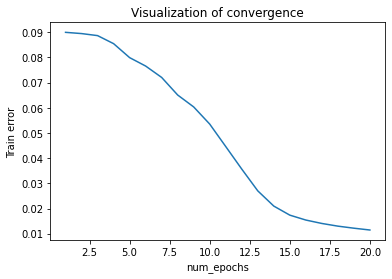

Accuracy of the model : 92.87 %


0.9287374128582494

In [34]:
model = Model3Hidden()
num_epochs = 20
batch_size = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, model)

#### b) iii. Model with 4 hidden layers

In [49]:
class Model4Hidden(nn.Module):
    
    def __init__(self, hidden_layer_1=100, hidden_layer_2=100, hidden_layer_3=100, hidden_layer_4=400):
        super(Model4Hidden, self).__init__()
        
        self.l1 = nn.Linear(16*16, hidden_layer_1)
        self.l2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.l3 = nn.Linear(hidden_layer_2, hidden_layer_3)
        self.l4 = nn.Linear(hidden_layer_3, hidden_layer_4)
        self.l5 = nn.Linear(hidden_layer_4, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h1 = F.relu(self.l1(inputs))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        h4 = F.relu(self.l4(h3))
        outputs = F.softmax(self.l5(h4), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Epoch [1/20], Loss: 0.0899
Epoch [2/20], Loss: 0.0896
Epoch [3/20], Loss: 0.0893
Epoch [4/20], Loss: 0.0891
Epoch [5/20], Loss: 0.0887
Epoch [6/20], Loss: 0.0868
Epoch [7/20], Loss: 0.0810
Epoch [8/20], Loss: 0.0775
Epoch [9/20], Loss: 0.0756
Epoch [10/20], Loss: 0.0732
Epoch [11/20], Loss: 0.0669
Epoch [12/20], Loss: 0.0617
Epoch [13/20], Loss: 0.0564
Epoch [14/20], Loss: 0.0487
Epoch [15/20], Loss: 0.0411
Epoch [16/20], Loss: 0.0363
Epoch [17/20], Loss: 0.0307
Epoch [18/20], Loss: 0.0252
Epoch [19/20], Loss: 0.0199
Epoch [20/20], Loss: 0.0159


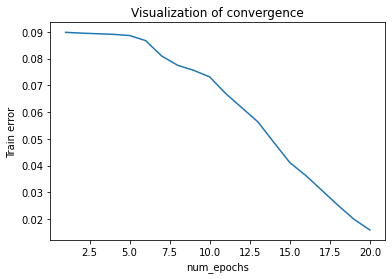

Accuracy of the model : 89.62 %


0.8962044926413633

In [50]:
model = Model4Hidden()
num_epochs = 20
batch_size = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, model)

#### c) Impact of the size of the hidden layer

Accuracy with 5 nodes in the hidden layer: 48.02 %
Accuracy with 10 nodes in the hidden layer: 92.80 %
Accuracy with 20 nodes in the hidden layer: 94.35 %
Accuracy with 50 nodes in the hidden layer: 93.88 %
Accuracy with 100 nodes in the hidden layer: 93.73 %
Accuracy with 200 nodes in the hidden layer: 94.19 %


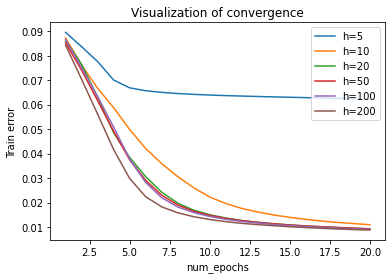

In [51]:
num_epochs = 20
batch_size = 10

for hidden_layer in [5, 10, 20, 50, 100, 200]:
    model = Model(hidden_layer)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="h={}".format(hidden_layer))
    
    acc = accuracy(val_set, model, logs=False)
    print("Accuracy with {} nodes in the hidden layer: {:.2f} %".format(hidden_layer, 100*acc))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()

#### d) Impact of the activation function

Accuracy with activation 'Softmax': 94.50 %
Accuracy with activation 'Sigmoid': 92.87 %
Accuracy with activation 'Tanh': 96.51 %
Accuracy with activation 'ReLU': 92.80 %


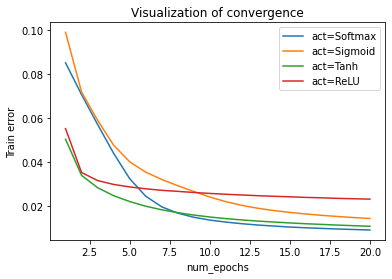

In [36]:
num_epochs = 20
batch_size = 10

activation_names = ["Softmax", "Sigmoid", "Tanh", "ReLU"]
for i, activation in enumerate([F.softmax, torch.sigmoid, torch.tanh, F.relu]):
    model = Model(activation=activation)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="act={}".format(activation_names[i]))
    
    acc = accuracy(val_set, model, logs=False)
    print("Accuracy with activation '{}': {:.2f} %".format(activation_names[i], 100*acc))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()


Accuracy with activation 'Softmax': 95.35 %
Accuracy with activation 'Sigmoid': 95.66 %
Accuracy with activation 'Tanh': 97.21 %
Accuracy with activation 'ReLU': 90.40 %


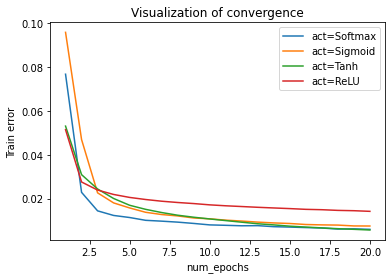

In [37]:
# Convolutional network

num_epochs = 20
batch_size = 10

activation_names = ["Softmax", "Sigmoid", "Tanh", "ReLU"]
for i, activation in enumerate([F.softmax, torch.sigmoid, torch.tanh, F.relu]):
    model = ModelConv(activation=activation)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="act={}".format(activation_names[i]))
    
    acc = accuracy(val_set, model, reshape=False, logs=False)
    print("Accuracy with activation '{}': {:.2f} %".format(activation_names[i], 100*acc))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()


### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

#### a) Impact of the batch size

Accuracy with a batch size of 10: 96.20 %
Accuracy with a batch size of 20: 94.73 %
Accuracy with a batch size of 50: 93.57 %
Accuracy with a batch size of 100: 87.99 %
Accuracy with a batch size of 200: 17.66 %
Accuracy with a batch size of 500: 9.84 %
Accuracy with a batch size of 1000: 7.98 %


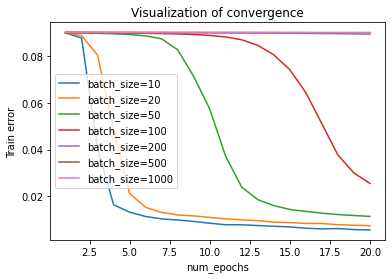

In [38]:
num_epochs = 20

for batch_size in [10, 20, 50, 100, 200, 500, 1000]:
    model = ModelConv()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="batch_size={}".format(batch_size))
    
    acc = accuracy(val_set, model, reshape=False, logs=False)
    print("Accuracy with a batch size of {}: {:.2f} %".format(batch_size, 100*acc))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()


#### b) i. Impact of the learning rate

Accuracy with a learning rate of 0.001: 17.74 %
Accuracy with a learning rate of 0.005: 33.15 %
Accuracy with a learning rate of 0.01: 58.71 %
Accuracy with a learning rate of 0.05: 93.03 %
Accuracy with a learning rate of 0.1: 94.66 %
Accuracy with a learning rate of 0.5: 95.97 %
Accuracy with a learning rate of 1: 97.13 %
Accuracy with a learning rate of 5: 97.44 %
Accuracy with a learning rate of 10: 94.04 %


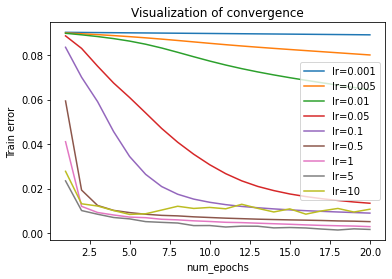

In [39]:
num_epochs = 20
batch_size = 10

for lr in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]:
    model = Model()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="lr={}".format(lr))
    
    acc = accuracy(val_set, model, logs=False)
    print("Accuracy with a learning rate of {}: {:.2f} %".format(lr, 100*acc))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()


#### b) ii. Impact of the learning rate on convolutional NN

Accuracy with a learning rate of 0.001: 10.15 %
Accuracy with a learning rate of 0.005: 19.21 %
Accuracy with a learning rate of 0.01: 86.91 %
Accuracy with a learning rate of 0.05: 95.04 %
Accuracy with a learning rate of 0.1: 95.66 %
Accuracy with a learning rate of 0.5: 97.99 %
Accuracy with a learning rate of 1: 97.60 %
Accuracy with a learning rate of 5: 8.83 %
Accuracy with a learning rate of 10: 17.66 %


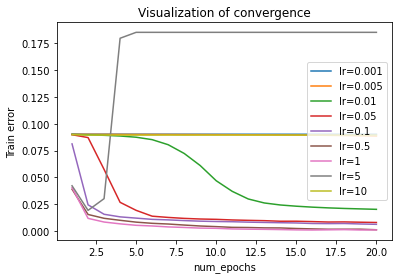

In [40]:
num_epochs = 20
batch_size = 10

for lr in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]:
    model = ModelConv()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="lr={}".format(lr))
    
    acc = accuracy(val_set, model, reshape=False, logs=False)
    print("Accuracy with a learning rate of {}: {:.2f} %".format(lr, 100*acc))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()


#### c) Impact of the number of epochs

Accuracy after 10 epochs: 93.80 %
Accuracy after 20 epochs: 96.67 %
Accuracy after 50 epochs: 97.06 %
Accuracy after 100 epochs: 96.98 %
Accuracy after 200 epochs: 97.13 %


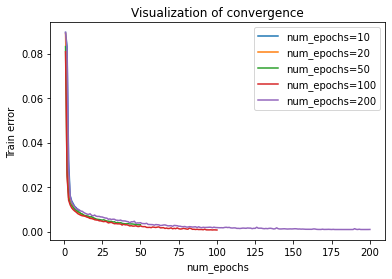

In [41]:
batch_size = 10

for num_epochs in [10, 20, 50, 100, 200]:
    model = ModelConv()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="num_epochs={}".format(num_epochs))
    
    acc = accuracy(val_set, model, reshape=False, logs=False)
    print("Accuracy after {} epochs: {:.2f} %".format(num_epochs, 100*acc))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()


#### d) Impact of the optimizer

Accuracy with the 'SGD' optimizer: 95.97 %
Accuracy with the 'ADAM' optimizer: 97.37 %
Accuracy with the 'RMSprop' optimizer: 96.98 %


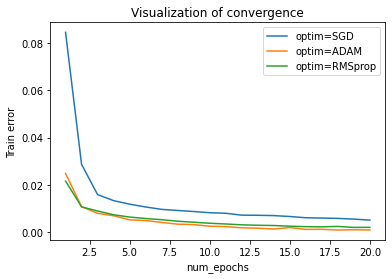

In [42]:
num_epochs = 20
batch_size = 10

optimizer_names = ["SGD", "ADAM", "RMSprop"]
for i, optimizer_function in enumerate([torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]):
    model = ModelConv()
    if optimizer_names[i] == "SGD":
        lr = 0.1
    else:
        lr = 0.001
    optimizer = optimizer_function(model.parameters(), lr=lr)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="optim={}".format(optimizer_names[i]))
    
    acc = accuracy(val_set, model, reshape=False, logs=False)
    print("Accuracy with the '{}' optimizer: {:.2f} %".format(optimizer_names[i], 100*acc))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()


### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

Epoch [1/20], Loss: 0.5170
Epoch [2/20], Loss: 0.2081
Epoch [3/20], Loss: 0.1487
Epoch [4/20], Loss: 0.1054
Epoch [5/20], Loss: 0.0828
Epoch [6/20], Loss: 0.0663
Epoch [7/20], Loss: 0.0538
Epoch [8/20], Loss: 0.0488
Epoch [9/20], Loss: 0.0445
Epoch [10/20], Loss: 0.0378
Epoch [11/20], Loss: 0.0350
Epoch [12/20], Loss: 0.0194
Epoch [13/20], Loss: 0.0278
Epoch [14/20], Loss: 0.0215
Epoch [15/20], Loss: 0.0226
Epoch [16/20], Loss: 0.0244
Epoch [17/20], Loss: 0.0155
Epoch [18/20], Loss: 0.0101
Epoch [19/20], Loss: 0.0049
Epoch [20/20], Loss: 0.0123


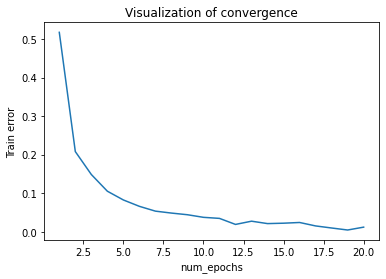

Accuracy of the model : 97.75 %


0.9775367931835787

In [43]:
model = ModelConv(activation=None)

num_epochs = 20
batch_size = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, model, reshape=False)

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [18]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open(project_folder+'/USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [19]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root=project_folder+'/USPS/',
                                     train=False,
                                     transform=transforms.ToTensor(),
                                     download=False)

Epoch [1/20], Loss: 0.5178
Epoch [2/20], Loss: 0.2320
Epoch [3/20], Loss: 0.1651
Epoch [4/20], Loss: 0.1347
Epoch [5/20], Loss: 0.0994
Epoch [6/20], Loss: 0.0878
Epoch [7/20], Loss: 0.0604
Epoch [8/20], Loss: 0.0599
Epoch [9/20], Loss: 0.0422
Epoch [10/20], Loss: 0.0392
Epoch [11/20], Loss: 0.0366
Epoch [12/20], Loss: 0.0284
Epoch [13/20], Loss: 0.0295
Epoch [14/20], Loss: 0.0202
Epoch [15/20], Loss: 0.0162
Epoch [16/20], Loss: 0.0218
Epoch [17/20], Loss: 0.0266
Epoch [18/20], Loss: 0.0161
Epoch [19/20], Loss: 0.0135
Epoch [20/20], Loss: 0.0059


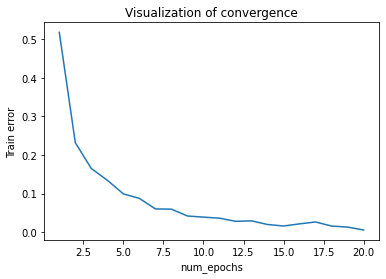

Accuracy of the model : 98.45 %


0.9845081332300543

In [46]:
model = ModelConv(activation=None)

num_epochs = 20
batch_size = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, model, reshape=False)

In [47]:
accuracy(test_set, model, reshape=False)

Accuracy of the model : 94.57 %


0.9456900847035377

Epoch [1/30], Loss: 0.7061
Epoch [2/30], Loss: 0.2774
Epoch [3/30], Loss: 0.2224
Epoch [4/30], Loss: 0.1777
Epoch [5/30], Loss: 0.1460
Epoch [6/30], Loss: 0.1275
Epoch [7/30], Loss: 0.1045
Epoch [8/30], Loss: 0.0909
Epoch [9/30], Loss: 0.0770
Epoch [10/30], Loss: 0.0577
Epoch [11/30], Loss: 0.0533
Epoch [12/30], Loss: 0.0472
Epoch [13/30], Loss: 0.0466
Epoch [14/30], Loss: 0.0362
Epoch [15/30], Loss: 0.0290
Epoch [16/30], Loss: 0.0275
Epoch [17/30], Loss: 0.0351
Epoch [18/30], Loss: 0.0218
Epoch [19/30], Loss: 0.0205
Epoch [20/30], Loss: 0.0236
Epoch [21/30], Loss: 0.0221
Epoch [22/30], Loss: 0.0178
Epoch [23/30], Loss: 0.0180
Epoch [24/30], Loss: 0.0222
Epoch [25/30], Loss: 0.0144
Epoch [26/30], Loss: 0.0170
Epoch [27/30], Loss: 0.0076
Epoch [28/30], Loss: 0.0104
Epoch [29/30], Loss: 0.0236
Epoch [30/30], Loss: 0.0133


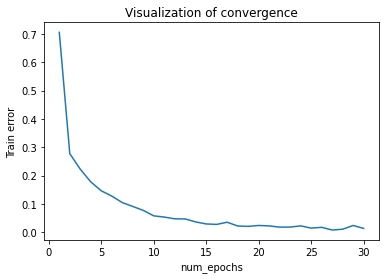

Accuracy of the model : 96.59 %


0.9659178931061193

In [20]:
bmodel = ModelConv(activation=None)

num_epochs = 30
batch_size = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, model, reshape=False)

Epoch [1/40], Loss: 0.5365
Epoch [2/40], Loss: 0.2142
Epoch [3/40], Loss: 0.1507
Epoch [4/40], Loss: 0.1158
Epoch [5/40], Loss: 0.0992
Epoch [6/40], Loss: 0.0799
Epoch [7/40], Loss: 0.0766
Epoch [8/40], Loss: 0.0561
Epoch [9/40], Loss: 0.0453
Epoch [10/40], Loss: 0.0366
Epoch [11/40], Loss: 0.0305
Epoch [12/40], Loss: 0.0446
Epoch [13/40], Loss: 0.0268
Epoch [14/40], Loss: 0.0267
Epoch [15/40], Loss: 0.0228
Epoch [16/40], Loss: 0.0191
Epoch [17/40], Loss: 0.0248
Epoch [18/40], Loss: 0.0196
Epoch [19/40], Loss: 0.0205
Epoch [20/40], Loss: 0.0145
Epoch [21/40], Loss: 0.0093
Epoch [22/40], Loss: 0.0145
Epoch [23/40], Loss: 0.0136
Epoch [24/40], Loss: 0.0076
Epoch [25/40], Loss: 0.0093
Epoch [26/40], Loss: 0.0248
Epoch [27/40], Loss: 0.0065
Epoch [28/40], Loss: 0.0049
Epoch [29/40], Loss: 0.0031
Epoch [30/40], Loss: 0.0132
Epoch [31/40], Loss: 0.0297
Epoch [32/40], Loss: 0.0071
Epoch [33/40], Loss: 0.0064
Epoch [34/40], Loss: 0.0026
Epoch [35/40], Loss: 0.0019
Epoch [36/40], Loss: 0.0022
E

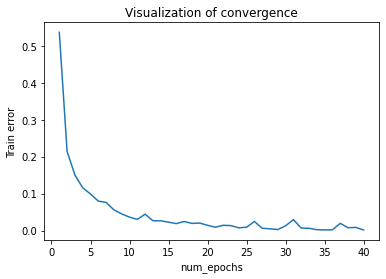

Accuracy of the model : 97.83 %


0.9783113865220759

In [21]:
model = ModelConv(activation=None)

num_epochs = 40
batch_size = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, reshape=False)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, model, reshape=False)

In [22]:
accuracy(test_set, model, reshape=False)

Accuracy of the model : 94.37 %


0.9436970602889886